In [163]:
# import necessary libraries

#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb
#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/int_logistic_regression.ipynb
#http://localhost:8888/lab/tree/MyQuantFinProject/SMart-AI/DemoDataTransform.ipynb

import math

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures

from datetime import date, timedelta, datetime # Date Functions
import time


from google.cloud import bigquery
from google.oauth2 import service_account
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# from google.cloud import aiplatform as vertex_ai
from tensorflow.python.keras.utils import data_utils

tf.__version__

'2.11.0'

In [164]:
cateCols=['sla','product_type','brand','service_type','incident_type']
# cateCols=['sla','product_type','service_type','incident_type']

numbericCols=['open_to_close_hour','response_to_resolved_hour']
#numbericCols=['open_to_close_hour']

unusedCols=['severity_id','severity_name','label_binary_severity']
#unusedCols=['severity_id','severity_name','label_binary_severity','brand','response_to_resolved_hour']

labelCol='label_multi_severity'

model_dir='model' # production
#model_dir='demo_model' # demo


main_metric='accuracy'
main_objective=f'val_{main_metric}'


nEarlyPatience=10
#nEarlyPatience=5

# df['label_multi_severity'] =df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3}) 

In [165]:
# Load data from BigQuery
projectId='smart-data-ml'
dataset_id='SMartML'

In [166]:
train_name='train_incident'
validation_name='validation_incident'
test_name='test_incident'

# Load Data

In [167]:
client_bq = bigquery.Client()

In [168]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
  
 return df

In [169]:
train_table_id=f"{projectId}.{dataset_id}.{train_name}"
val_tabel_id=f"{projectId}.{dataset_id}.{validation_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"


credentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
client = bigquery.Client(credentials=credentials, project=projectId)
# client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
val=load_data_bq(f"SELECT * FROM {val_tabel_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

# Load data from CSV File
# root_path='../../data'    
# train = load_ml_data(f"{root_path}/{train_name}.csv")
# val=load_ml_data(f"{root_path}/{validation_name}.csv")
# test =load_ml_data(f"{root_path}/{test_name}.csv")

print(train.shape)
print(val.shape)
print(test.shape)


(2218, 8)
(277, 8)
(278, 8)


In [170]:
labelList=list(train[labelCol].unique())
print("List All Label:" ,sorted(labelList))
nLabel=len(labelList)
print(f"No target label : {nLabel}")

print(train.info())
train.tail()

List All Label: [0, 1, 2, 3]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        2218 non-null   object 
 1   product_type               2218 non-null   object 
 2   brand                      2218 non-null   object 
 3   service_type               2218 non-null   object 
 4   incident_type              2218 non-null   object 
 5   open_to_close_hour         2218 non-null   float64
 6   response_to_resolved_hour  2218 non-null   float64
 7   label_multi_severity       2218 non-null   Int64  
dtypes: Int64(1), float64(2), object(5)
memory usage: 140.9+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity
2213,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,2.000000,1.916667,1
2214,24x7 4Hrs Response Time,Software,Trend Micro,Incident,General Incident,248.116667,71.666667,1
2215,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,306.583333,306.200000,2
2216,24x7 4Hrs Response Time,Security,Trend Micro,Incident,Software,51.166667,51.166667,2
2217,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,Configuration Change,119.616667,119.033333,2


In [171]:
def CalPctEachTargetClass(dfx,colSev,colPctSev):
    dfClassSummary=dfx.groupby([labelCol]).size().to_frame(colSev)
    dfClassSummary[colPctSev]= dfClassSummary[colSev]/dfClassSummary[colSev].sum() *100
    dfClassSummary=dfClassSummary.round(0)
    return dfClassSummary

pctDF1=CalPctEachTargetClass(train,'Train-No-Severity','Train-%-Severity')
pctDF2=CalPctEachTargetClass(val,'Val-No-Severity','Val-%-Severity')
pdcDF3=CalPctEachTargetClass(test,'Test-No-Severity','Test-%-Severity')
pctDF=pd.concat([pctDF1,pctDF2,pdcDF3],axis=1)

pctDF

,Train-No-Severity,Train-%-Severity,Val-No-Severity,Val-%-Severity,Test-No-Severity,Test-%-Severity
label_multi_severity,,,,,,
0,390,18.0,55,20.0,48,17.0
1,676,30.0,66,24.0,71,26.0
2,1065,48.0,143,52.0,142,51.0
3,87,4.0,13,5.0,17,6.0


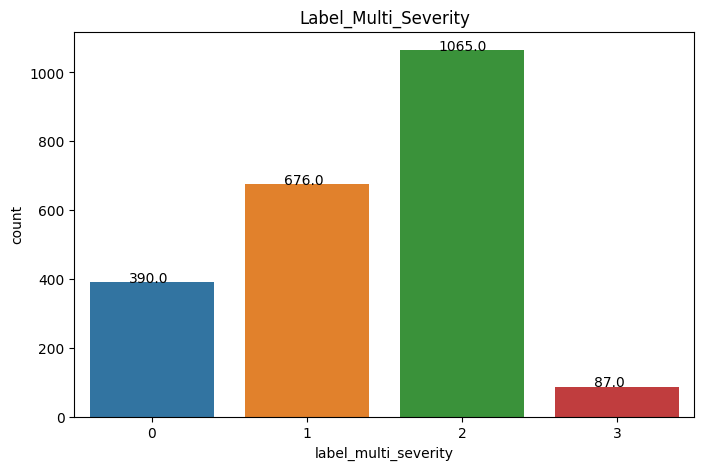

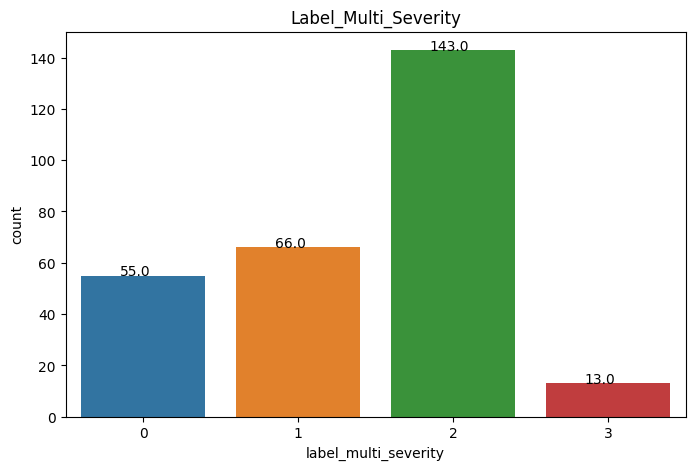

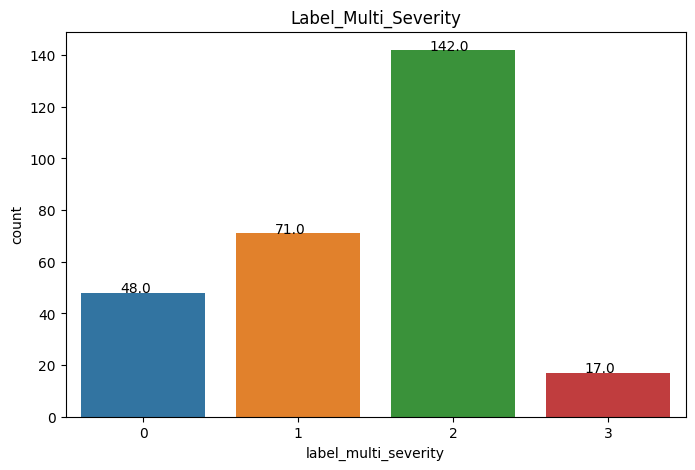

In [172]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x=labelCol, data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol.title())
    plt.show()
    
plot_class(train)
plot_class(val)
plot_class(test)

# Process Data  Layer

In [173]:
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(labels, num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [174]:
print("Explore Data from Tensor before keras data processing")
batch_size = 1
train_ds =multiple_label_df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print("========Features==========")
print('Every feature:', list(train_features.keys()))
print('product_type:', train_features['product_type'])  # sample cate feature
print('open_to_close_hour:', train_features['open_to_close_hour'])  # sample numberic feature


Explore Data from Tensor before keras data processing
========Features==========
Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
product_type: tf.Tensor([b'Server'], shape=(1,), dtype=string)
open_to_close_hour: tf.Tensor([1.51666667], shape=(1,), dtype=float64)


In [175]:
print("========Labels==========")
print(f'{label_batch }')

========Labels==========
[[0. 0. 1. 0.]]


In [176]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [177]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [178]:
hour_col = train_features['open_to_close_hour']
layer = get_normalization_layer('open_to_close_hour', train_ds)
layer(hour_col)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.36092088], dtype=float32)>

In [179]:
# total no type+unkonw
print(train['product_type'].unique())
type_col = train_features['product_type']
layer = get_category_encoding_layer('product_type', train_ds, 'string')
layer(type_col)

# onehot-encoding = 10 category+unknown=11 columnn

['Other' 'Printer' 'Storage' 'Software' 'Server' 'Switch' 'Access Point'
 'Hardware' 'Security' 'Tape Library' 'Firewall']


<tf.Tensor: shape=(12,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [180]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)
# for element in train_ds.as_numpy_iterator():
#     print(element)

# Full Process Layer

In [181]:
all_inputs = []
encoded_features = []
numInputFeatToInitNodeUnit=0

# Numeric features.
for header in numbericCols:
  stat_data=train[header].describe()
  print(f"header: Mean={stat_data['mean']} and Std={stat_data['std']}")  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)
    
numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+len(numbericCols)
    
    # Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  listCateItem=train[header].unique()
  noCateItem=len(listCateItem)
  numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+noCateItem +1  # last 1 is unknow
    
  print(f"{header} = {noCateItem} : {listCateItem}")

  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


print(f"Total column to initialize first node input: {numInputFeatToInitNodeUnit}")

header: Mean=108.29700180342651 and Std=295.92343514692345
header: Mean=82.47289600240457 and Std=253.13708758280043
sla = 7 : ['24x7 4Hrs Resolution Time' '24x7 4Hrs Response Time'
 '24x7 6Hrs Resolution Time' '8x5 4Hrs Response Time' 'Non MA'
 '24x7 6Hrs Response Time' '9x5 NBD 4Hrs Response Time']
sla
product_type = 11 : ['Other' 'Printer' 'Storage' 'Software' 'Server' 'Switch' 'Access Point'
 'Hardware' 'Security' 'Tape Library' 'Firewall']
product_type
brand = 27 : ['F5' 'HP' 'EMC' 'HPE' 'IBM' 'YIP' 'DELL' 'QNAP' 'Cisco' 'SAPB1' 'Veeam'
 'NetApp' 'Oracle' 'VMWare' 'eUnite' 'Nutanix' 'Red Hat' 'Veritas'
 'Alfresco' 'Broadcom' 'Fortinet' 'Commvault' 'Microsoft' 'Palo Alto'
 'CIMCO-CMMS' 'CheckPoint' 'Trend Micro']
brand
service_type = 2 : ['Request' 'Incident']
service_type
incident_type = 21 : ['Configuration Change' 'Maintenance System' 'General Incident' 'Software'
 'Hard Disk Drive Failure' 'Report' 'Controller/Node Failure'
 'Network Adapter Failure' 'Upgrade Software' 'OS / Fi

# Build and Train and Eveluate and Plot Result

In [182]:
def plot_metrics(history,metric):
    plt.figure(figsize=(15,8))
    plt.title(metric)
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='validation')
    plt.legend()
    plt.show() 


In [183]:
# def build_model(num_units_1,num_units_layer2, dropout_rate):
def build_model(num_units_layer1, dropout_rate,learningRate):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
   
    x = tf.keras.layers.Dense(num_units_layer1, activation="relu")(all_features)
    
    if dropout_rate>0:
     x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # x = tf.keras.layers.Dense(num_units_layer1, activation="relu")(x)
    # if dropout_rate>0:
    #  x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)

    model = tf.keras.Model(all_inputs, output)
    
    if  learningRate==0:
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[main_metric])
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
                      loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[main_metric])
    return model

# def build_wide_deep_model()


In [184]:

# METRICS = [
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]

def train_model(model,x_epochs,x_batch_size):  
    # model.summary()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=nEarlyPatience, verbose=1)  
    # loss
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor=main_objective, patience=nEarlyPatience, verbose=1)  
    # accuray
    
    history =model.fit(train_ds, validation_data=val_ds,epochs=x_epochs,batch_size=x_batch_size,callbacks=[early_stopping])
    return history
  



# Test Run Model

In [185]:
print("1#Build model")

# smaller RL , longer , By doing this, you learn gradually rather than jumping around 
#A learning rate of 0.001 is the default (Adam)
#{'units': 32, 'Dropout_rate': 0.1}
# model=build_model(32,0.1,0)
model=build_model(numInputFeatToInitNodeUnit,0.1,0)

print("2#Train model")
history=train_model(model,100,32)
print("=============================================================================")



1#Build model
2#Train model
Epoch 1/100
70/70 [==============================] - 2s 10ms/step - loss: 1.1480 - accuracy: 0.4856 - val_loss: 0.9634 - val_accuracy: 0.5884
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 0.8966 - accuracy: 0.6506 - val_loss: 0.8201 - val_accuracy: 0.7292
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7899 - accuracy: 0.6894 - val_loss: 0.7672 - val_accuracy: 0.6751
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7450 - accuracy: 0.7051 - val_loss: 0.7413 - val_accuracy: 0.6751
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 0.7284 - accuracy: 0.6970 - val_loss: 0.7387 - val_accuracy: 0.6787
Epoch 6/100
70/70 [==============================] - 0s 4ms/step - loss: 0.7070 - accuracy: 0.7069 - val_loss: 0.7375 - val_accuracy: 0.6787
Epoch 7/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.7178 - val_loss: 0.7221 - val_a

In [186]:
print("3#Evaluate model")

loss_val, accuracy_val = model.evaluate(val_ds)
print(f"Average Loss - Accuracy on Eveluation {loss_val} -{accuracy_val}")

loss_test, accuracy_test = model.evaluate(test_ds)
print(f"Average Loss - Accuracy on Test {loss_test} -{accuracy_test}")

print("=============================================================================")


# production data set to 12MAr23
# 7/7 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.7689
# Average Loss - Accuracy on Eveluation 0.6654592752456665 -0.7688679099082947
# 7/7 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.7358
# Average Loss - Accuracy on Test 0.6977102160453796 -0.7358490824699402


# demo set to 04 April23
# 8/8 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.7621
# Average Loss - Accuracy on Eveluation 0.7333917617797852 -0.7621145248413086
# 8/8 [==============================] - 0s 3ms/step - loss: 0.7452 - accuracy: 0.6740
# Average Loss - Accuracy on Test 0.745168149471283 -0.6740087866783142
# ============================================================================

3#Evaluate model
9/9 [==============================] - 0s 3ms/step - loss: 0.7488 - accuracy: 0.7148
Average Loss - Accuracy on Eveluation 0.7488210797309875 -0.7148014307022095
9/9 [==============================] - 0s 3ms/step - loss: 0.7646 - accuracy: 0.7122
Average Loss - Accuracy on Test 0.7646445631980896 -0.7122302055358887


4#Explore Result model


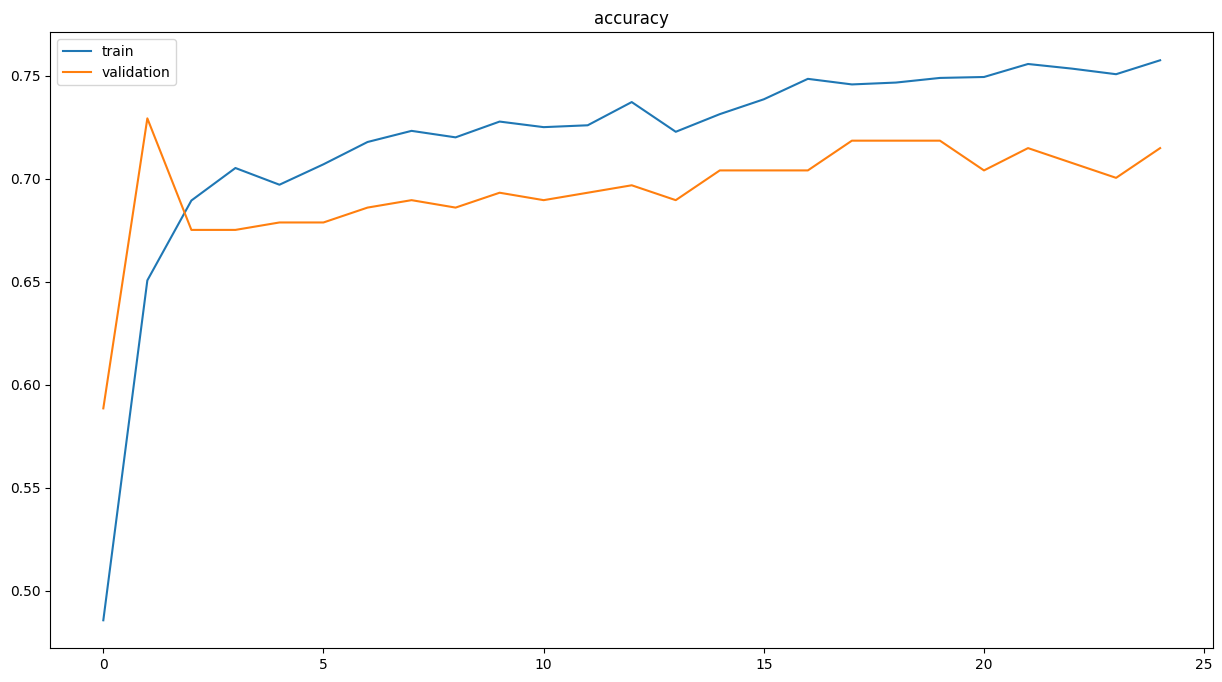

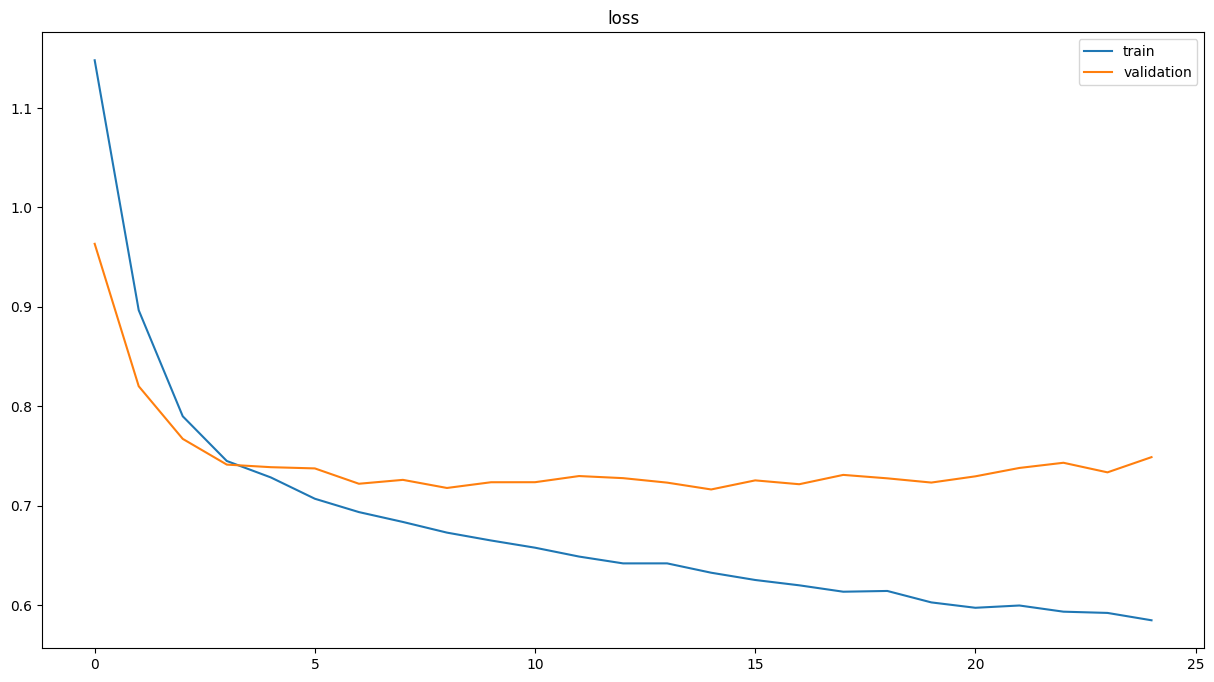

In [187]:
print("4#Explore Result model")
plot_metrics(history,main_metric)
plot_metrics(history,"loss")


# Save Model

In [188]:
model.save(model_dir)

# OUTPUT_DIR = "babyweight_trained"
# shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
# EXPORT_PATH = os.path.join(
#     OUTPUT_DIR, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
# tf.saved_model.save(
#     obj=model, export_dir=EXPORT_PATH)  # with default serving function
# print("Exported trained model to {}".format(EXPORT_PATH))


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


# Save Model+MetaData for being Explainable AI

# Test Predict

In [189]:
#label_multi_severity

m = tf.keras.models.load_model(model_dir)

sample={"sla":"24x7 4Hrs Response Time",
        "product_type":"Server",
        "brand":"VMWare",                
        "service_type":"Incident",
        "incident_type":"General Incident",
        "open_to_close_hour":10,
        "response_to_resolved_hour":6.000000 \
       }

print(sample)
              
print("===============================================================================================================")    
print("convert pain data to serdor as input to predict")    
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
print(input_dict)

predictionList = m.predict(input_dict)
print(predictionList)


{'sla': '24x7 4Hrs Response Time', 'product_type': 'Server', 'brand': 'VMWare', 'service_type': 'Incident', 'incident_type': 'General Incident', 'open_to_close_hour': 10, 'response_to_resolved_hour': 6.0}
convert pain data to serdor as input to predict
{'sla': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'24x7 4Hrs Response Time'], dtype=object)>, 'product_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Server'], dtype=object)>, 'brand': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'VMWare'], dtype=object)>, 'service_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Incident'], dtype=object)>, 'incident_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'General Incident'], dtype=object)>, 'open_to_close_hour': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([10])>, 'response_to_resolved_hour': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.], dtype=float32)>}
1/1 [==============================] - 0s 447ms/step
[[0.02085448 0.1735905

In [190]:
prob = tf.nn.softmax(predictionList[0])
print(f"{(100 * prob)} % at {np.argmax(prob, axis=0)} as Severity") 
print()

[18.861929 21.974478 40.136955 19.026632] % at 2 as Severity



# Copy Model From Local To GCS

In [192]:
# #https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#6
# press_y3=input(f"Press y=True to save model to Google Cloud storage : ") 
# if press_y3.lower()=='y':
MODEL_BUCKET = 'gs://tf1-incident-smart-ml-yip'

# # # !gsutil mb -l $REGION $MODEL_BUCKET
# !gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/demo_model
!gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/model
#!gsutil -m cp -r ./$explain_meta_model_dir/* $MODEL_BUCKET/demo_model_explain_meta
# else:
#  quite()


Copying file://.\model\fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://.\model\saved_model.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/523.0 KiB]   0% Done                                    
Copying file://.\model\keras_metadata.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/523.0 KiB]   0% Done                                    
Copying file://.\model\variables\variables.index [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/523.0 KiB]   0% Done                                    
Copying file://.\model\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/523.0 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/523.0 KiB]   0% Done                                    
/ [1/5 files][ 38.9 KiB/523.0 KiB]   7% Done                                    
/ [2/5 files][523.0 KiB/523.0 KiB]  99% Done                          

# Import Model to Vertex AI

In [ ]:
# https://console.cloud.google.com/vertex-ai/models?project=pongthorn
# name=tf_dnn_incident_pongthorn1
# region =asia-southeast1
# prebuild =tensorflow 11 
# model path =gs://tf1-incident-pongthorn/model/


# https://cloud.google.com/vertex-ai/docs/model-registry/import-model#get-operation


#https://codelabs.developers.google.com/vertex-p2p-predictions#3
# Import model manually
#https://console.cloud.google.com/vertex-ai/models?project=pongthorn
# Upload wand wait for vertex to complete process (Email notification)
# if run package ( you need to specify precuild-pacage


#Import model programactically
# https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers

# from google.cloud import aiplatform
# DEPLOY_IMAGE = "asia-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-6:latest"

# model = aip.Model.upload(
#     display_name="ponghthorn_xgb_" + TIMESTAMP,
#     artifact_uri=MODEL_DIR,
#     serving_container_image_uri=DEPLOY_IMAGE,
#     sync=False,
# )

# model.wait()


# Deploy Model to EndPoint

In [ ]:
#https://codelabs.developers.google.com/vertex-p2p-predictions#4
# Manual

#https://console.cloud.google.com/vertex-ai/endpoints?project=pongthorn
#spec E2

# Program
# my_model = aiplatform.Model("projects/{PROJECT_NUMBER}/locations/us-central1/models/{MODEL_ID}") 

# endpoint = my_model.deploy(
#      deployed_model_display_name='my-endpoint',
#      traffic_split={"0": 100},
#      machine_type="n1-standard-4",
#      accelerator_count=0,
#      min_replica_count=1,
#      max_replica_count=1,
#    )

In [95]:
# Deploy to AIPlatform (Deprecated)
# MODEL = MODEL_NAME
# VERSION = 'v1'
# model_path = MODEL_BUCKET + '/model'

# # !gcloud ai-platform models create $MODEL --region=$REGION

# MACHINE_TYPE='n1-standard-2'

# !gcloud  ai-platform versions create $VERSION --model $MODEL --origin $model_path --runtime-version 2.11 --framework TENSORFLOW --machine-type $MACHINE_TYPE --python-version 3.7 --region=$REGION
# !gcloud ai-platform versions describe $VERSION --model $MODEL --region=$REGION